In [1]:
using DrWatson
@quickactivate "momdist"

In [2]:
using Ripserer, PersistenceDiagrams, PersistenceDiagramsBase
using Random, Distributions, Parameters, Pipe, ProgressMeter, Plots, StatsPlots, JLD2
using Distances, LinearAlgebra, Statistics, LazySets, Roots, LambertW, LaTeXStrings

ProgressMeter.ijulia_behavior(:clear)

In [3]:
import RobustTDA as rtda

### Helper Functions

In [17]:
function randomRotation(; d=3)
    A = randn(d, d)
    M = (A + A') ./ √2
    _, U = eigen(M)
    return U
end

randomRotation (generic function with 1 method)

In [18]:
function interlockedCircles(n; args...)
    R = [1 0 0; 0 0 -1; 0 1 0]
    X1 = [[x...; 0] for x in rtda.randCircle(n)]
    X2 = [R * ([x...; 0] .+ [1.0, 0.0, 0.0]) for x in rtda.randCircle(n)]
    return [X1; X2]
end

interlockedCircles (generic function with 1 method)

## Generate Points from Interlocked Circles in $\R^{100}$

In [23]:
Random.seed!(2022)
m = 150
n = 7 * m
dim = 100
R = randomRotation(d=dim)

signal = interlockedCircles(n)
signal = [Tuple(R * [x...; zeros(dim - 3)]) for x in signal]

l = 0.23
R = product_distribution(repeat([Uniform(-l, l)], dim))
noise = [rand(R) for _ in 1:m]

X = [signal; noise] |> rtda._ArrayOfVectors_to_ArrayOfTuples
Xn = [[x...] for x in X];

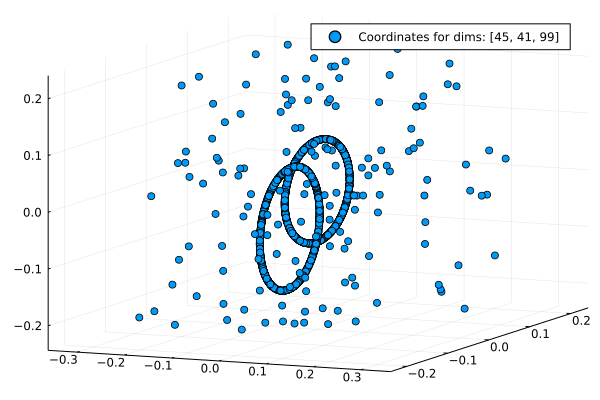

In [26]:
dims = rand(1:1:100, 3)
@pipe [x[dims] for x in X] |> scatter(_, ratio=1, label="Coordinates for dims: $dims")

### Calibration using Lepski's method

In [27]:
# Initialize Lepski Parameters

θ = rtda.lepski_params(
    a=0.1,
    b=1,
    mmin=100,
    mmax=500,
    pi=1.15,
    δ=0.01
)

M = rtda.lepski(Xn=Xn, params=θ)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /storage/home/s/suv87/work/julia_depot/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress:  82%|█████████████████████████████████▌       |  ETA: 0:01:21
  m:  231

231

Optionally, we can refine the method by reusing the estimate from the previous run with a smaller value of $\pi$

In [29]:
# Refined Lepski

θ = rtda.lepski_params(
    a=0.2,
    b=1,
    mmin=round(Int, 0.8 * M),
    mmax=round(Int, 1.2 * M),
    pi=1.07,
    δ=0.01
)

M = rtda.lepski(Xn=Xn, params=θ)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /storage/home/s/suv87/work/julia_depot/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:10
  m:  227

227

In [28]:
Q = 2 * M + 1

Random.seed!(2022)
dnq = rtda.momdist(Xn, floor(Int, Q))
dnm = rtda.dtm(Xn, Q / n)

w_momdist = rtda.fit(Xn, dnq)
w_dtm = rtda.fit(Xn, dnm)

D1 = rtda.wrips(Xn, w=w_momdist, p=1)
D2 = rtda.wrips(Xn, w=w_dtm, p=1)

2-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 2250-element 0-dimensional PersistenceDiagram
 3-element 1-dimensional PersistenceDiagram

In [ ]:
plot(
    plot(D1[2], ylim=(-0.5, 1.5), persistence=true), 
    plot(D2[2], ylim=(-0.5, 1.5), persistence=true)
)